### Предлагаю Вам выполнить следующее тестовое задание.<br> 
Необходимо натренировать нейронную сеть, которая на вход будет принимать картинку со словом, а на выходе - определяет шрифт, которым написан текст. <br> 
Для начала возьмите порядка 10 разных шрифтов. <br> 
Датасеты для обучения и валидации Вам предлагается сгенерировать самостоятельно. <br> 
Фреймворк для обучения сети - TensorFlow, язык скриптов - Python. <br> Оформление задачи в виде Jupyter notebook приветствуется. 

<br> 
##### Выполнил: Евгений Сорока 

In [1]:
import tensorflow as tf

import numpy as np
from scipy.misc import imresize

import matplotlib.pyplot as plt
from matplotlib import rcParams
from skimage import io
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm import tqdm

plt.style.use('ggplot')
#rcParams['figure.figsize'] = 10, 8
seed = 256

%matplotlib inline

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Загрузим сгенированный датасет. 
Датасет включает в себя 1300 уникальных слов, каждое слово имеет 10 различных написаний, в зависимости от шрифта.
Используемые шрифты: 
<li>arial
<li>bookman
<li>calibri
<li>century
<li>comic
<li>dotum
<li>georgia
<li>gost
<li>tahoma
<li>times new roman


In [2]:
directory = os.listdir('data/')

fonts = [os.path.join('data', d+'/') for d in os.listdir('data/')]
data_links = sorted([os.path.join(f, i) for f in fonts for i in os.listdir(f)])

len(data_links)

In [5]:
labels = np.array([np.zeros(1300, dtype=np.int32)+i for i in range(0, 10)]).flatten()
labels.shape

(13000,)

In [6]:
data_raw = np.array([io.imread(img, as_grey=True).astype(np.float32) for img in data_links])

Преообразуем изображения к единому виду.

In [7]:
data = np.array([imresize(img, (28, 126)) for img in data_raw])
data = np.array([img[:,:-26] for img in data])

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [8]:
%store data_raw
del data_raw

Stored 'data_raw' (ndarray)


In [9]:
data.shape

(13000, 28, 100)

Посмотрим как выглядят обьекты

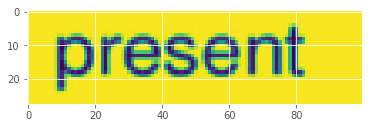

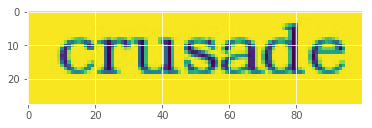

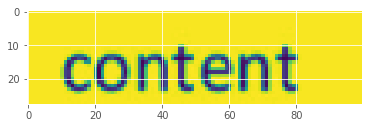

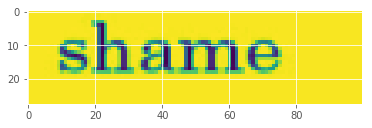

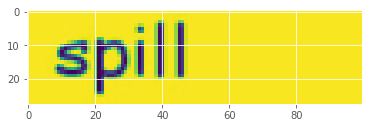

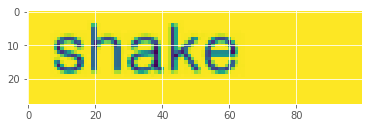

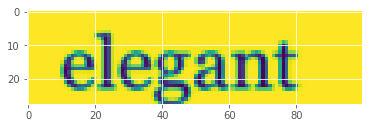

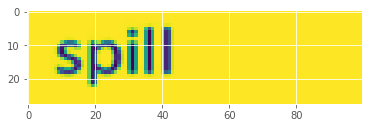

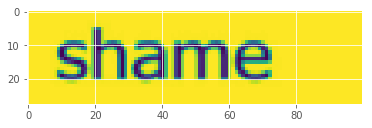

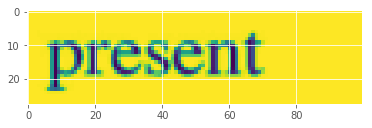

In [10]:
for i in np.linspace(0, 13000, 10, endpoint=False, dtype=np.int32):
    plt.figure()
    plt.imshow(data[i])

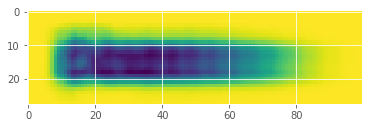

In [11]:
mean = data.mean(axis=0)
plt.imshow(mean)

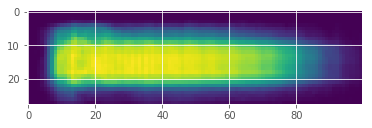

In [12]:
stddev = data.std(axis=0)
plt.imshow(stddev)

Преобразуем целевые переменные в бинарный формат

In [13]:
def onehot(y):
    a = np.zeros((y.shape[0], 10))
    a[np.arange(y.shape[0]), y] = 1
    print(a[0])
    return a

y = onehot(labels)
y.shape

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(13000, 10)

In [14]:
train = data[:,:,:,np.newaxis] / 255
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.25, random_state=seed)
print(X_train.shape)
print(X_test.shape)
print(np.sum(y_train, axis=0))


(9750, 28, 100, 1)
(3250, 28, 100, 1)
[971. 953. 975. 994. 978. 973. 968. 978. 972. 988.]


In [15]:
%store data
del data

Stored 'data' (ndarray)


Построим модель подходом библиотеки Keras, но на Tensorflow

In [ ]:
model = tf.keras.Sequential(name='CNN')
model.add(tf.keras.layers.Conv2D(32, kernel_size=(4, 4),
                                 activation='relu',
                                 input_shape=X_train.shape[1:]))
model.add(tf.keras.layers.Conv2D(64, (4, 4), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

In [ ]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
# Изменил размер пакета с 256 на 128, чтобы более точно найти глобальный минимум градиента.
n_epochs = 10
batch_size = 128

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=n_epochs,
          verbose=1,
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Сохраним модель и полученные веса


In [48]:
model.save_weights("weights.h5")
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [49]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_test = np.argmax(y_test, 1)

Построим confusion matrix и classification report

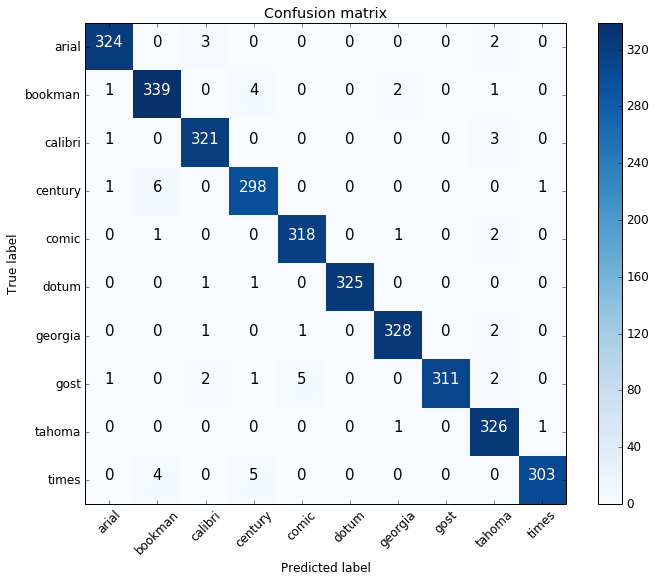

In [50]:
import itertools

cmatrix = confusion_matrix(y_test, y_pred)
classes = ['arial', 'bookman', 'calibri', 'century', 'comic', 'dotum', 'georgia', 'gost', 'tahoma', 'times'] 

def plot_confusion_matrix(cmatrix, classes, cmap=plt.cm.Blues):

    #print(cmatrix)
    plt.style.use('classic')
    plt.imshow(cmatrix, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cmatrix.max() / 2.
    for i, j in itertools.product(range(cmatrix.shape[0]), range(cmatrix.shape[1])):
        plt.text(j, i, format(cmatrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cmatrix[i, j] > thresh else "black", fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plt.figure(figsize=(10,8))
plot_confusion_matrix(cmatrix, classes)    

In [51]:
print(classification_report(y_test, y_pred, target_names=classes))

             precision    recall  f1-score   support

      arial       0.99      0.98      0.99       329
    bookman       0.97      0.98      0.97       347
    calibri       0.98      0.99      0.98       325
    century       0.96      0.97      0.97       306
      comic       0.98      0.99      0.98       322
      dotum       1.00      0.99      1.00       327
    georgia       0.99      0.99      0.99       332
       gost       1.00      0.97      0.98       322
     tahoma       0.96      0.99      0.98       328
      times       0.99      0.97      0.98       312

avg / total       0.98      0.98      0.98      3250



In [52]:
fp_indeces = (~(y_test == y_pred)).nonzero()[0]

/home/eugenerodse/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


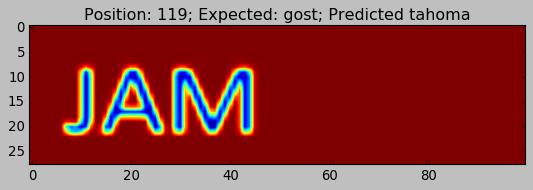

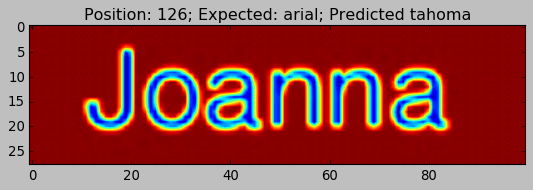

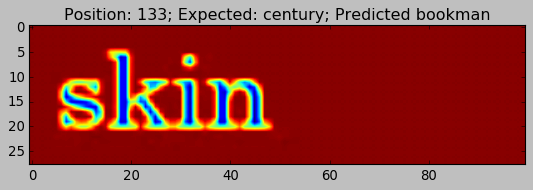

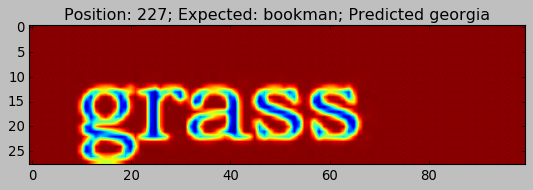

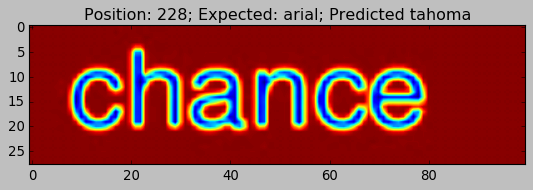

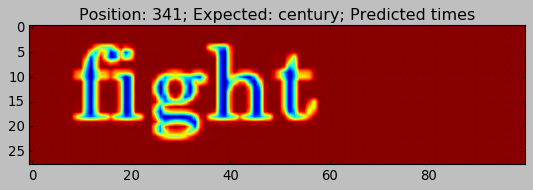

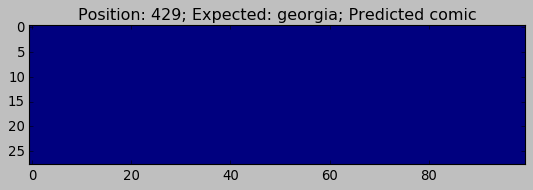

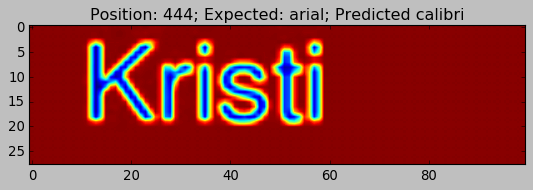

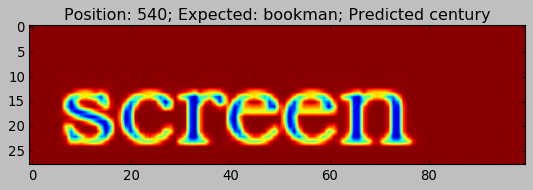

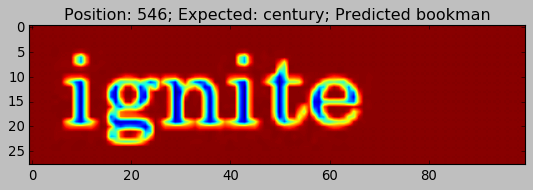

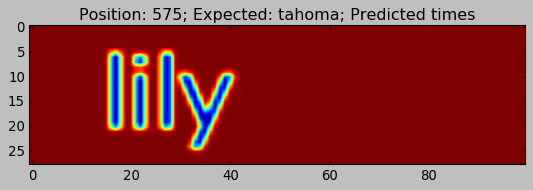

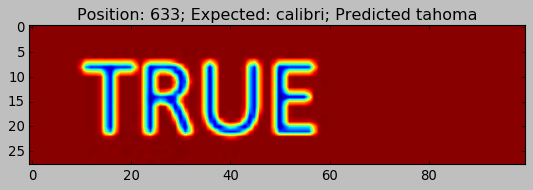

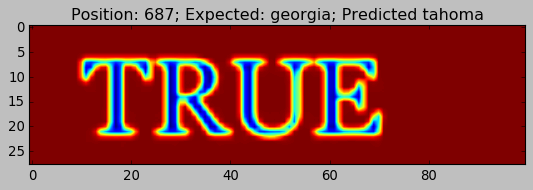

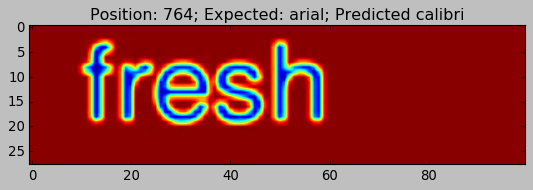

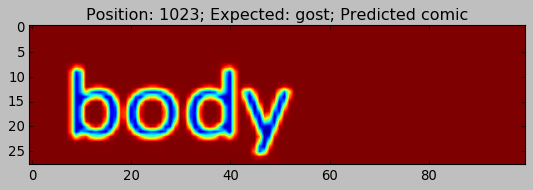

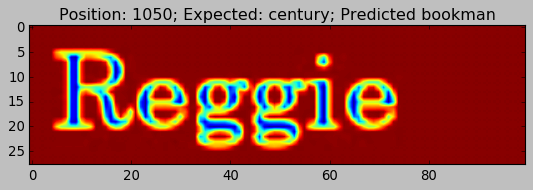

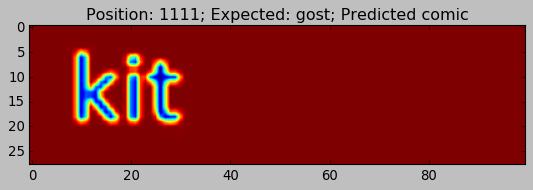

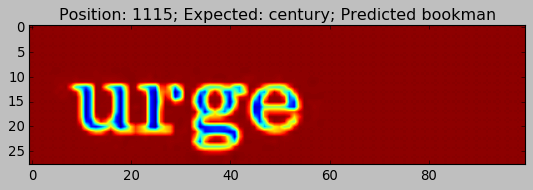

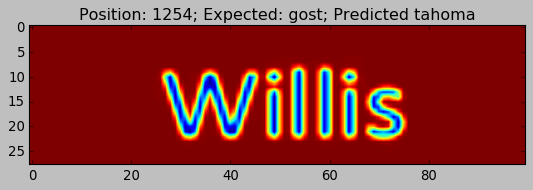

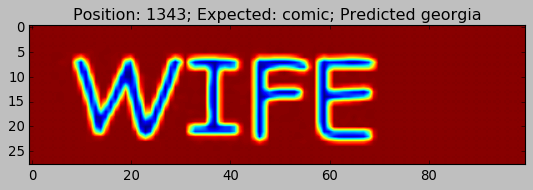

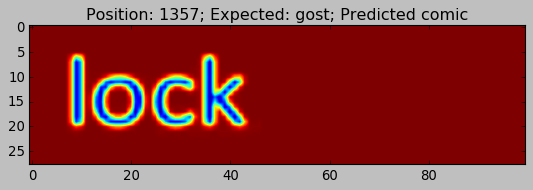

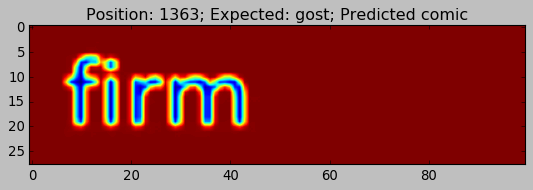

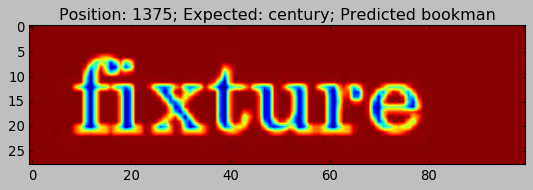

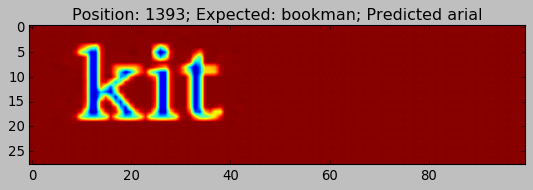

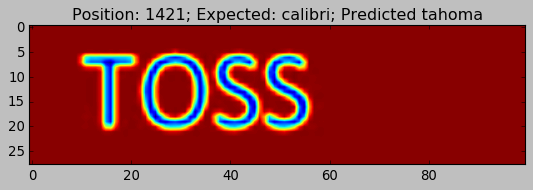

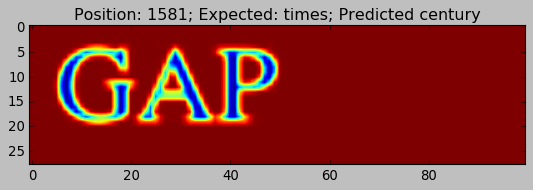

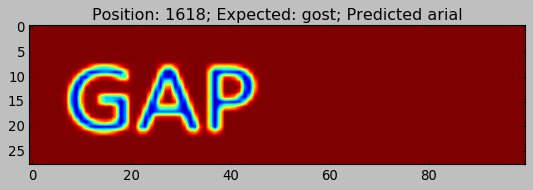

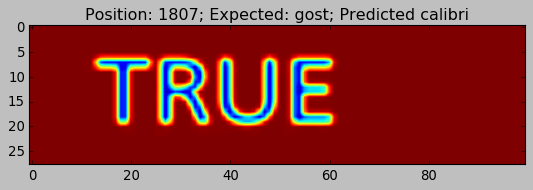

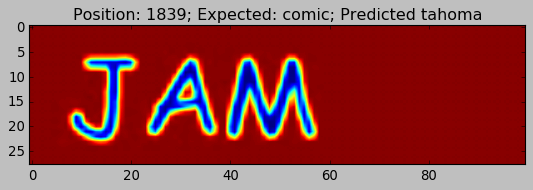

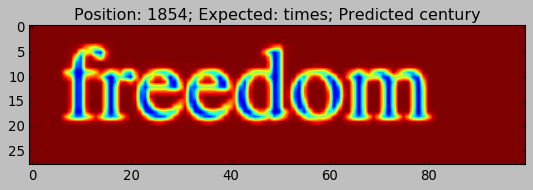

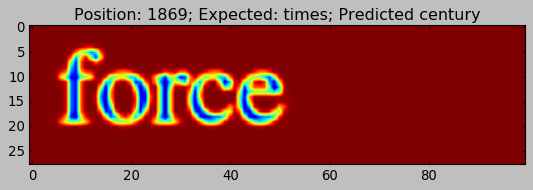

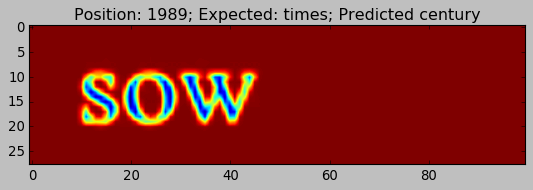

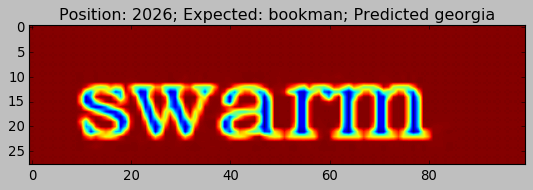

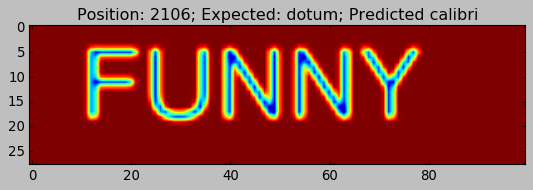

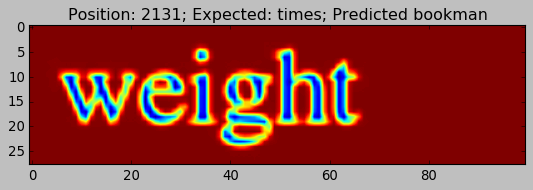

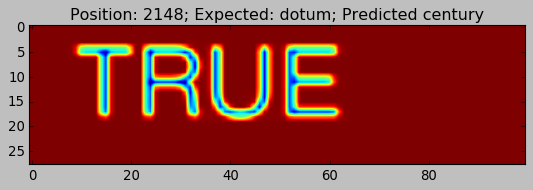

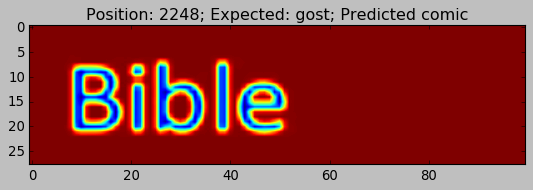

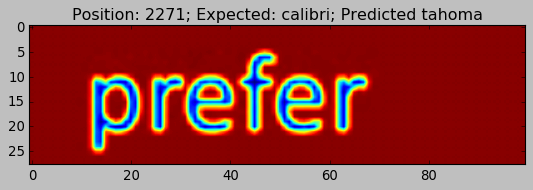

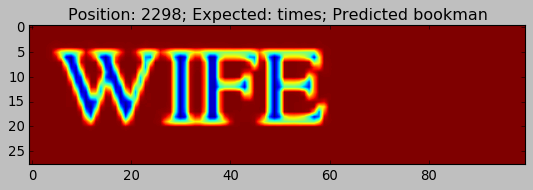

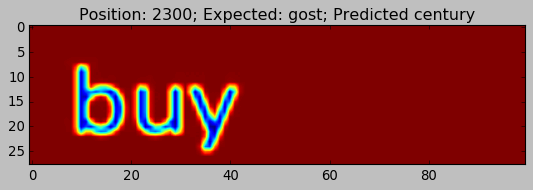

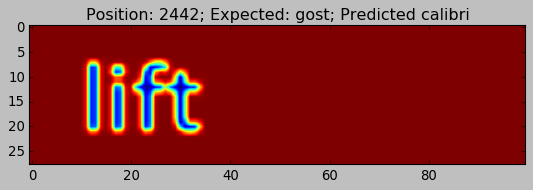

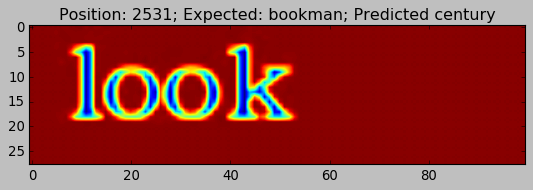

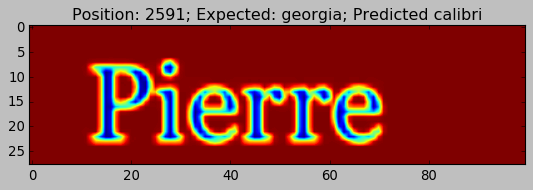

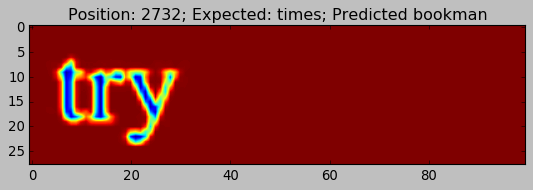

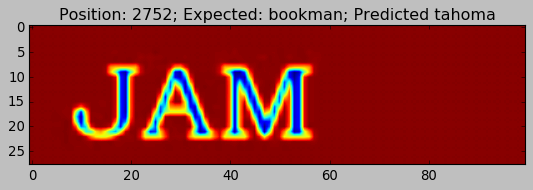

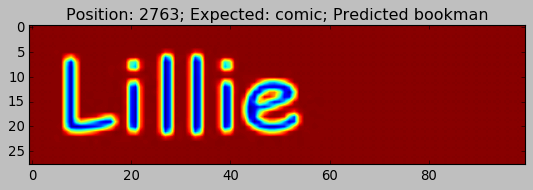

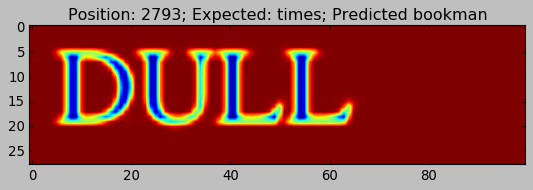

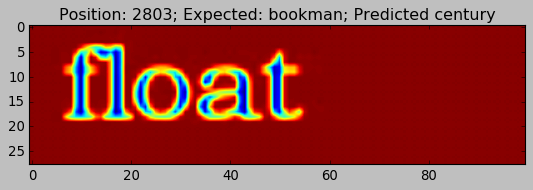

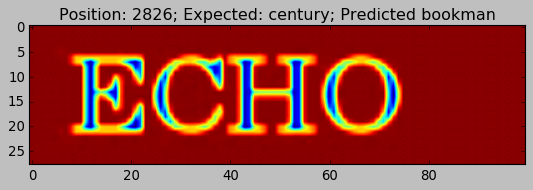

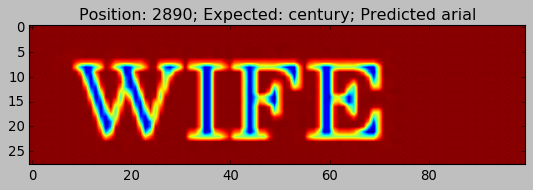

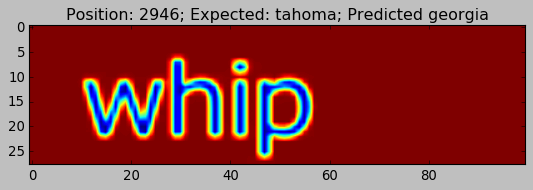

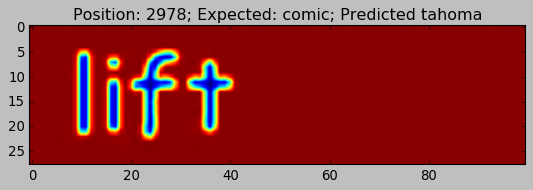

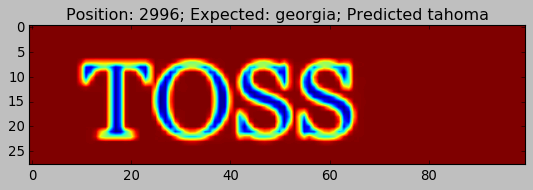

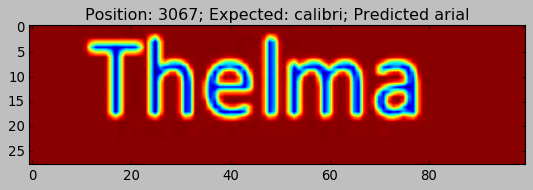

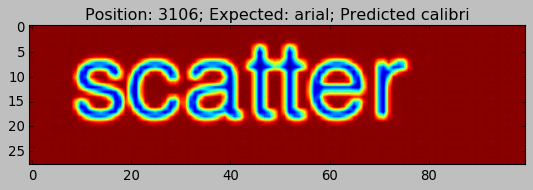

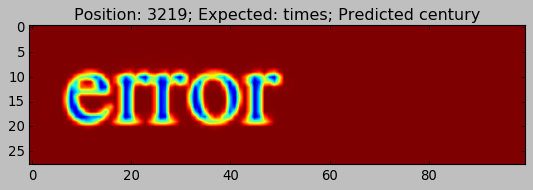

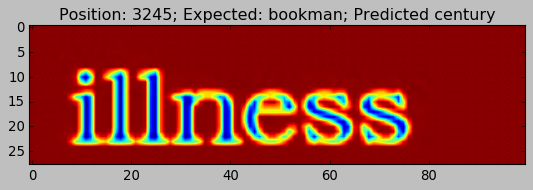

In [53]:
def plot_fp_results(indeces, classes):
    
    for i in indeces:
        plt.figure()
        plt.imshow(np.reshape(X_test[i], (28, 100)))
        plt.title('Position: {}; Expected: {}; Predicted {}'.format(i, classes[y_test[i]], classes[y_pred[i]]))

plot_fp_results(fp_indeces, classes)        